<a href="https://colab.research.google.com/github/tangYang7/GAI/blob/main/final_project/TOEIC_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📝 TOEIC 出題聊天小助手
- 動機
1. 剛好想練習一下英文的題目，就想說直接用AI幫我出題試看看
2. 目前學習型的 ChatBot 好像探討的還沒有很深入，想自己實際試看看效果

## 1. Install and import packages

In [16]:
! pip install gradio
! pip install openai

In [17]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr

In [18]:
import os
from google.colab import userdata

## 2. Setting Chatbot using API KEY

In [19]:
#【使用 Mistral】
# api_key = userdata.get('Mistral')
# base_url = "https://api.mistral.ai/v1"
# model = "ministral-8b-latest"

#【使用 OpenAI】
# api_key = userdata.get('OpenAI')
# model = "gpt-4o"

#【使用 Groq】
api_key = userdata.get('Groq')
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

#【使用 Gemini】
# api_key = userdata.get('Gemini')
# model="gemini-1.5-flash"
# base_url="https://generativelanguage.googleapis.com/v1beta/openai/"

#【使用 Together】
# api_key = userdata.get('Together')
# model = "meta-llama/Llama-Vision-Free"
# base_url="https://api.together.xyz/v1"

#【使用 Fireworks】
# api_key = userdata.get('Fireworks')
# model = "accounts/fireworks/models/llama-v3p2-3b-instruct"
# base_url = "https://api.fireworks.ai/inference/v1"

In [20]:
os.environ['OPENAI_API_KEY']=api_key

## 3. Build a chatbot

In [21]:
from openai import OpenAI
client = OpenAI(
    base_url = base_url # 如用 OpenAI 不需要這一行
)

In [27]:
# 🔧 工具函式：產生題目 prompt
def generate_toeic_prompt(part5_num, part7_num, difficulty, random_theme, teacher_style):
    return f"""
你現在是一位{teacher_style}的 TOEIC 英文老師，請你依照以下設定出題：

- Part 5 單句填空題數：{part5_num} 題
- Part 7 閱讀題數：{part7_num} 題
- 難度：{difficulty}
- 主題：{"隨機主題" if random_theme else "不限"}

請用以下格式輸出每一題：
題目編號. 題目內容
A. 選項A
B. 選項B
C. 選項C
D. 選項D

請勿給出「答案」或「解析」。
"""

# 只抽出題目本體（去除答案與解析）
def extract_question_only(full_text):
    lines = full_text.strip().split("\n")
    filtered = []
    for line in lines:
        if not line.startswith("答案：") and not line.startswith("解析："):
            filtered.append(line)
        else:
            break
    return "\n".join(filtered)

# 抽出答案與解析部分
def extract_answer_and_explanation(full_text):
    lines = full_text.strip().split("\n")
    answer_lines = []
    started = False
    for line in lines:
        if line.startswith("答案：") or line.startswith("解析："):
            started = True
        if started:
            answer_lines.append(line)
    return "\n".join(answer_lines)

# 出題階段：僅顯示題目（不含解析）
def handle_generate_click(part5, part7, level, theme, style):
    system_msg = {"role": "system", "content": f"你是一位{style}，擅長說明文法與單字，幫助學生準備 TOEIC 考試。"}
    user_prompt = {"role": "user", "content": generate_toeic_prompt(part5, part7, level, theme, style)}
    messages = [system_msg, user_prompt]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.7
    )

    full_question = response.choices[0].message.content
    visible_question = extract_question_only(full_question)

    return [{"role": "assistant", "content": visible_question}], full_question

# 使用者作答後顯示解析
def handle_user_answer(user_input, full_question, chat_history):
    chat_history.append({"role": "user", "content": f"我選擇：{user_input}"})

    # 這邊重新送出一個 prompt 要求模型根據原始題目給出解析
    messages = [
        {"role": "system", "content": "你是一位擅長解釋 TOEIC 題目的英文老師，請根據題目補充完整解答與解析。解析：解釋包含詞彙、文法、錯誤選項說明與例句，如果難度是中級或初級，請你附上英文解析跟中文解析，如果是高級的話就只用英文解析"},
        {"role": "user", "content": f"以下是題目內容，請補上正確答案與解析：\n\n{full_question}"}
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.7
    )

    answer_and_expl = response.choices[0].message.content
    reply = f"你的回答是：{user_input}\n\n正確解答與解析如下：\n{answer_and_expl}"
    chat_history.append({"role": "assistant", "content": reply})
    return chat_history, chat_history


# Gradio 介面
with gr.Blocks() as demo:
    gr.Markdown("""# 📝 TOEIC 出題聊天小助手
這是一個模擬 TOEIC 出題與互動練習的系統。
""")

    with gr.Row():
        with gr.Column(scale=1):
            part5_slider = gr.Slider(0, 10, value=3, label="Part 5 題數")
            part7_slider = gr.Slider(0, 5, value=2, label="Part 7 題數")
            difficulty = gr.Radio(["初級", "中級", "高級"], label="難度", value="中級")
            random_theme = gr.Checkbox(label="是否加入隨機主題")
            teacher_style = gr.Dropdown(["溫柔老師", "嚴格老師", "幽默教練"], label="老師風格", value="溫柔老師")
            generate_btn = gr.Button("✅ 開始出題")

        with gr.Column(scale=2):
            chatbot = gr.Chatbot(label="TOEIC 練習聊天區", type="messages")
            user_input = gr.Textbox(label="請輸入答案（例如 A）", placeholder="A / B / C / D")
            submit_btn = gr.Button("送出答案")
            chat_history = gr.State([])
            question_state = gr.State("")

    generate_btn.click(
        handle_generate_click,
        inputs=[part5_slider, part7_slider, difficulty, random_theme, teacher_style],
        outputs=[chatbot, question_state]
    )

    submit_btn.click(
        handle_user_answer,
        inputs=[user_input, question_state, chat_history],
        outputs=[chatbot, chat_history]
    )

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1da996751d22727b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 成果截圖及說明

1. 最一開始會進入這個畫面，選擇想要的題型及數量、難度還有老師風格，就可以開始出題

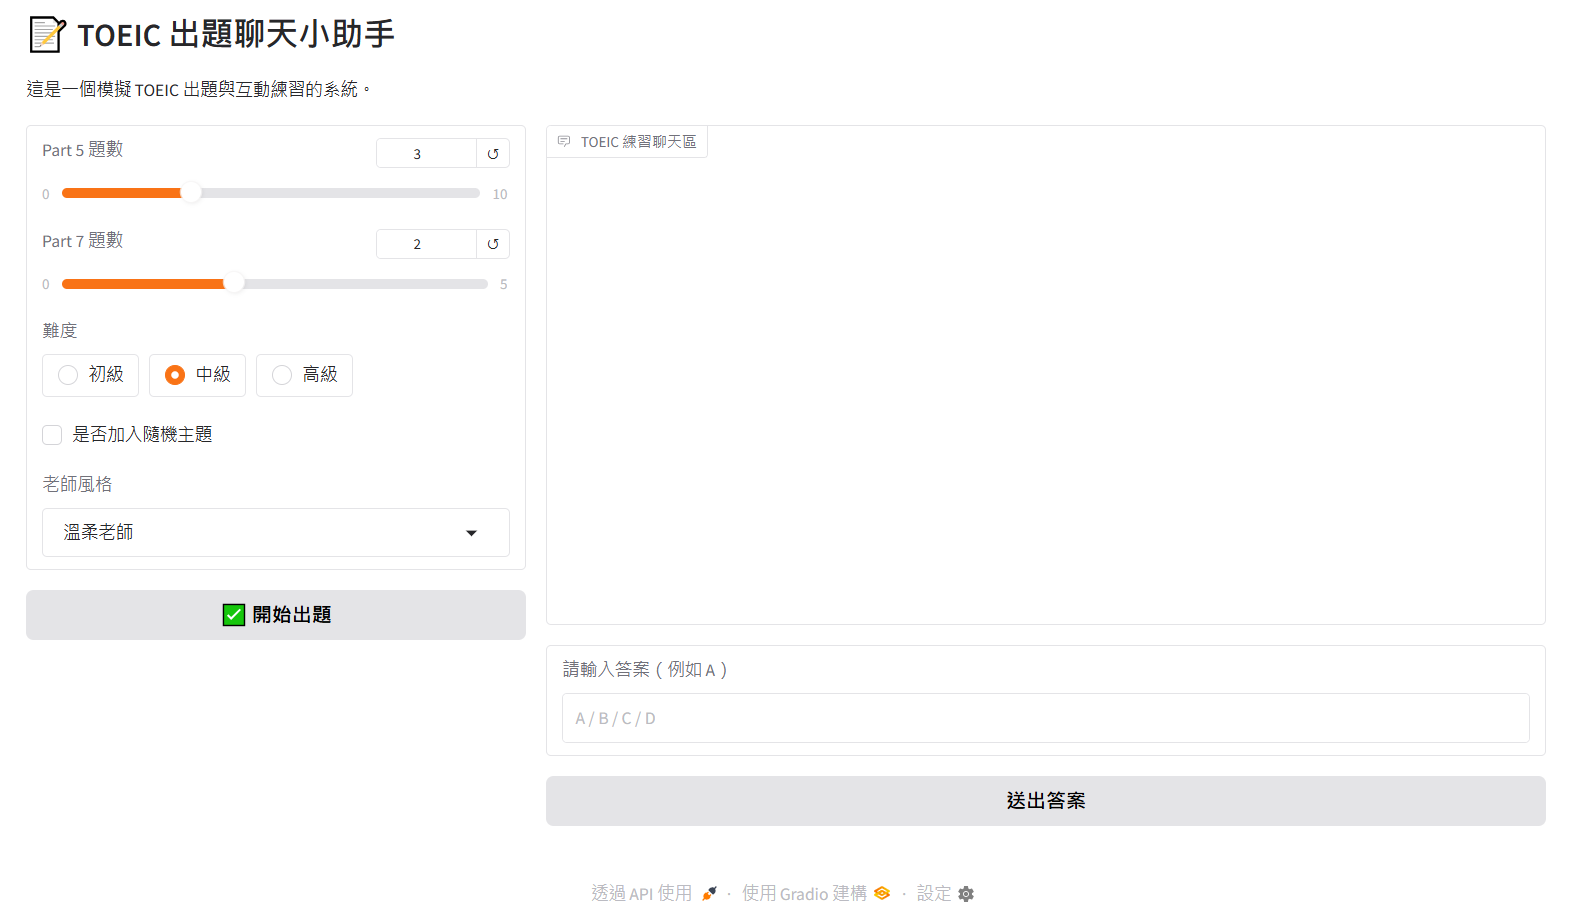

2. 出完題後，會如以下畫面：會有題目以及選項，在作答區作答完即可以送出

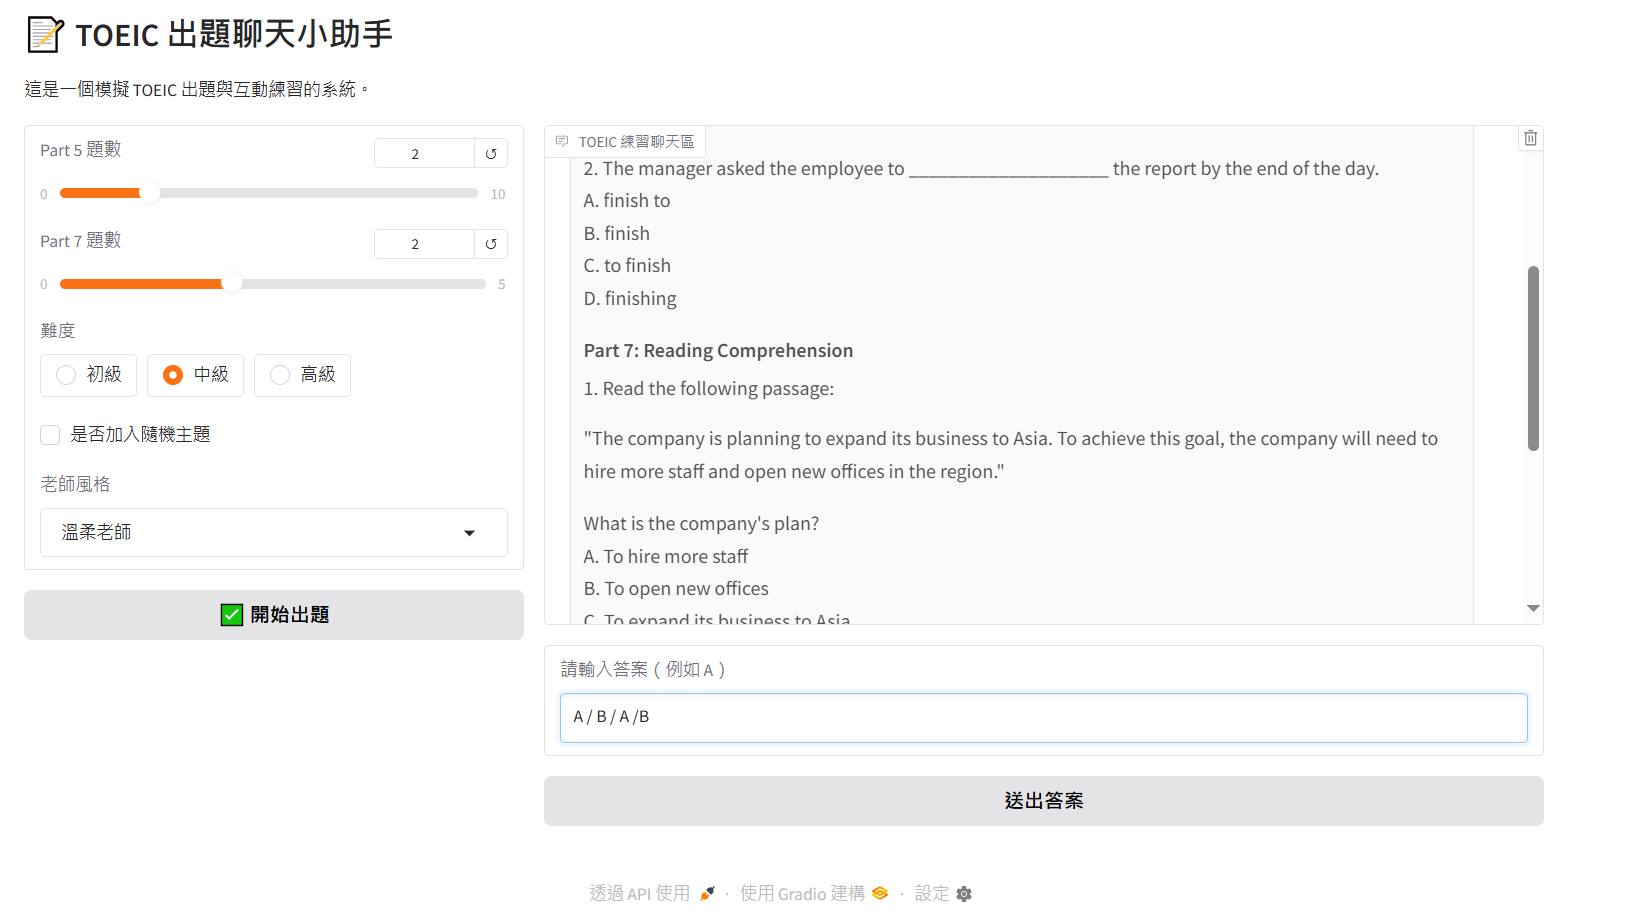

3. 點擊送出後，會出現題目解析

* 內容解析會包含英文以及中文的解釋

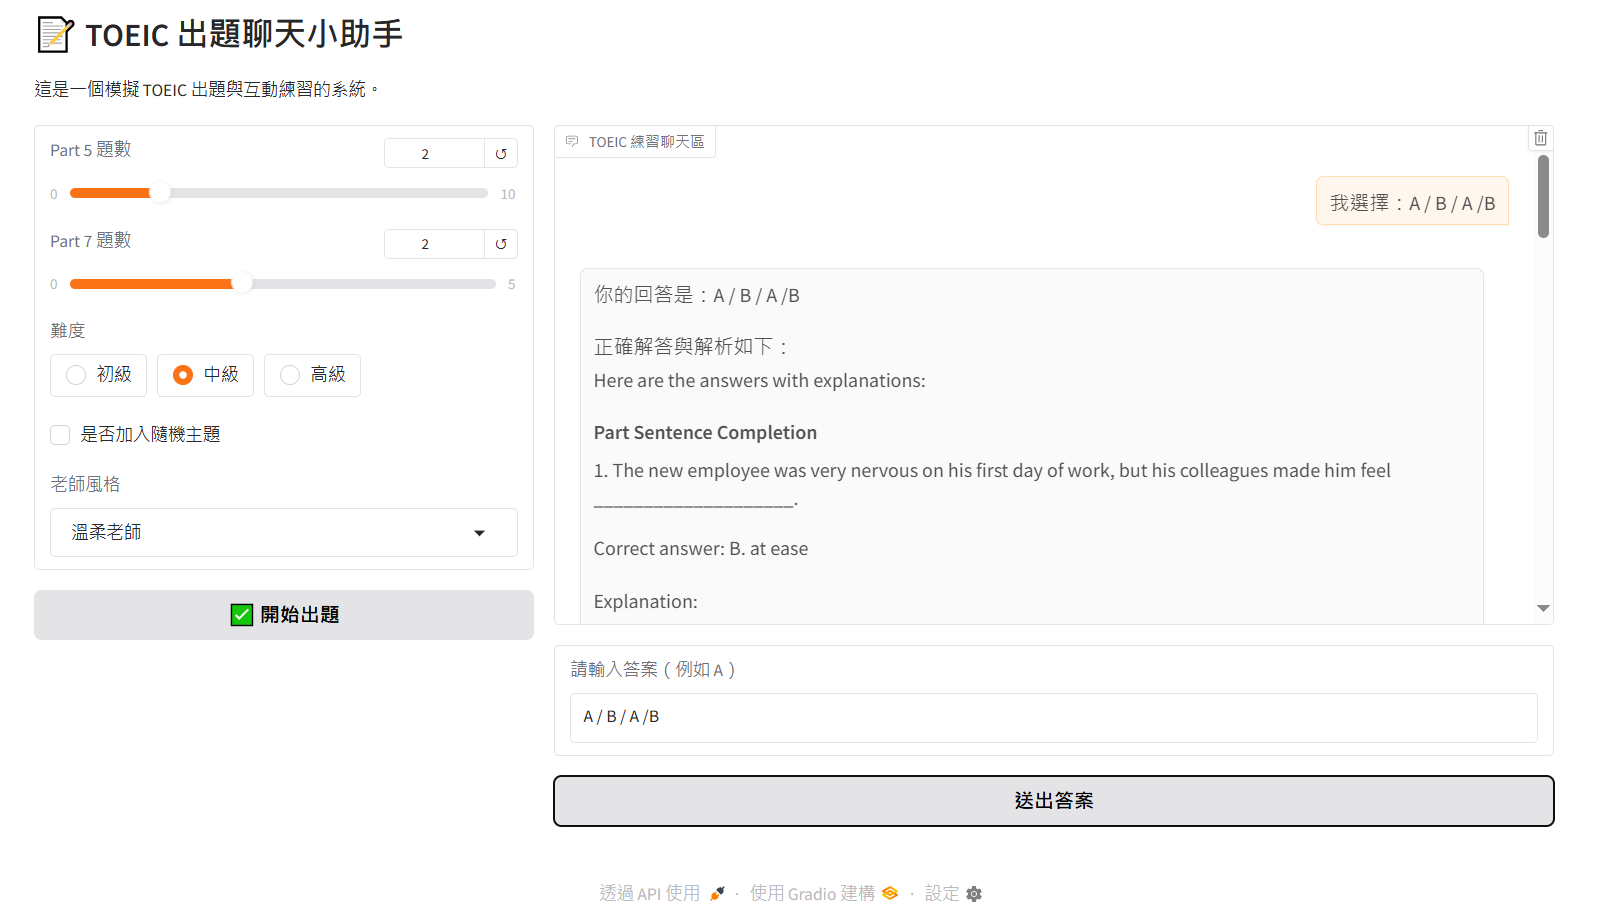

以剛剛的題目為例的解析：
*****
你的回答是：A / B / A /B

正確解答與解析如下：
Here are the answers and explanations:

Part 5: Sentence Completion

The company's new product has been a huge ____________________ since its launch last month.
Answer: A. success (noun) means "the achievement of something desirable or planned". In this sentence, "a huge success" means that the product has been very popular and successful since its launch.
Error analysis:

B. successfully (adverb) is not suitable here because it describes a verb, but "a huge" needs a noun.
C. failing (verb) is the opposite of "success", so it doesn't fit the context.
D. succeed (verb) doesn't fit grammatically.
English explanation:
The sentence requires a noun to complete the phrase "a huge _______". "Success" is a noun that fits the context, meaning the product has been very popular and successful.

中文解釋：
本題需要填入名詞，「success」是名詞，表示產品推出以來非常受歡迎和成功。

The manager asked the employee to ____________________ the report by the end of the day.
Answer: B. finish.
Error analysis:

A. finish to (incorrect preposition)
C. to finish (infinitive phrase, not suitable in this context)
finishing (verb, doesn't fit grammatically)
English explanation:
The sentence requires a verb to complete the instruction "asked the employee to _______". "Finish" is a verb that fits the context, meaning the employee needs to complete the report by the end of the day.

中文解釋：
本題需要填入動詞，「finish」是動詞，表示員工需要在今日結束前完成報告。

Part 7: Reading Comprehension

Read the following passage:
"The company is planning to expand its business to Asia. To achieve this goal, the company will need to hire more staff and open new offices in the region."
What is the company's plan?
Answer: C. To expand its business to Asia.
Error analysis:

A. To hire more staff (part of the plan, but not the main goal)
B. To open new offices (part of the plan, but not the main goal)
D. To achieve a goal (too general, doesn't specify what the goal is)
English explanation:
The passage states that the company plans to expand its business to Asia, and provides details on how to achieve this goal. Therefore, the correct answer is "To expand its business to Asia".

中文解釋：
文章指出公司計劃擴展到亞洲，並提供達成這個目標的細節。因此，正確答案是「擴展到亞洲」。

Read the following passage:
"The new employee was very nervous on his first day of work. His colleagues, however, were very friendly and helpful, which made him feel at ease."
How did the new employee's colleagues behave?
Answer: B. They were very friendly.
Error analysis:

A. They were very strict (opposite of the passage, which states they were friendly)
C. They were very busy (not mentioned in the passage)
D. They were very quiet (not mentioned in the passage)
English explanation:
The passage states that the colleagues were "very friendly and helpful", which made the new employee feel at ease. The correct answer is "They were very friendly".

中文解釋：
文章指出同事們非常友善和有幫助，使新員工感到放鬆。因此，正確答案是「他們非常友善」。
*****


4. 心得以及後續 Future work
* 優點：
  * 可以幫忙出題或是解答，還有附上英文以及中文的解析
  * 操作算是簡單容易上手，可以短時間就練習上幾題
* 缺點：
  * 沒有可以記憶之前答錯的題目
  * 感覺目前還是做得比較模板的感覺，還沒辦法說可以有很流暢的進一步提問、問答互動
  * 可以重複出題，但可能他出題容易出類似的題目
  
* Future work
  * 更多互動模式：有不同的模式可以互動，如：出題、聊天問答等等
  * 出題多樣化：可以有 RAG 之類的方式檢所題庫，或是可以不一樣的方式生成題目
  * 支援不同語言的測驗：如果也能做一個日文檢定的練習好像也不錯